# MGMGT 638-001 Assignment 4
Author: Francho Garcia Takis <br>
Date: 04-12-2024

### Importing Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from yellowbrick.model_selection import ValidationCurve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# Other
import beepy 
import warnings
warnings.filterwarnings('ignore')

### Importing Data
Features: 
- crim: per capita crime rate
- zn: proportion of residential land zoned for lots over 25,000 sq.ft.
- indus: proportion of non-retail business acres per town
- chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- nox: nitric oxides concentration (parts per 10 million)
- rm: average number of rooms per dwelling
- age: proportion of owner-occupied units built prior to 1940
- dis: weighted distances to ﬁve Boston employment centers
- rad: index of accessibility to radial highways
- tax: full-value property-tax rate per $10,000
- ptratio: pupil-teacher ratio by town
- lstat: % lower status of the population
- medv: Median value of owner-occupied homes in $1,000s

In [2]:
df = pd.read_csv('../data/BostonHousing.csv')
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


Only has 506 observations. This may be problematic for tuning some of the more complex models like the RF and MLP neural net.

In [272]:
#Checking data types of cols:
df.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
lstat      float64
medv       float64
dtype: object

In [305]:
#Checking for missing values:
df.isnull().sum()

crim           0
zn             0
indus          0
chas           0
nox            0
rm             0
age            0
dis            0
rad            0
tax            0
ptratio        0
lstat          0
medv           0
dis_nox        0
lstat_rm       0
lstat_age      0
lstat_indus    0
log_crim       0
dtype: int64

There are no missing values and the features are in their correct data types. 

### Basic Exploratory Data Analysis

In [273]:
features = [col for col in df.columns if col != 'medv']

In [ ]:
def plot_scatter(df, features=features, y='medv'):
    '''
    Function to plot each feature in the features list against the target variable y.
    3 plots per row.
    '''
    n = len(features) #num of features
    rows = n // 3  #num of rows
    cols = 3 #num of cols

    #Plotting:
    fig, ax = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    for i, feature in enumerate(features):
        row = i // cols
        col = i % cols
        ax[row, col].scatter(df[feature], df[y]) #Plot a scatte of each feature against the target var
        ax[row, col].set_xlabel(feature)
        ax[row, col].set_ylabel(y)
    plt.tight_layout()
    plt.show()

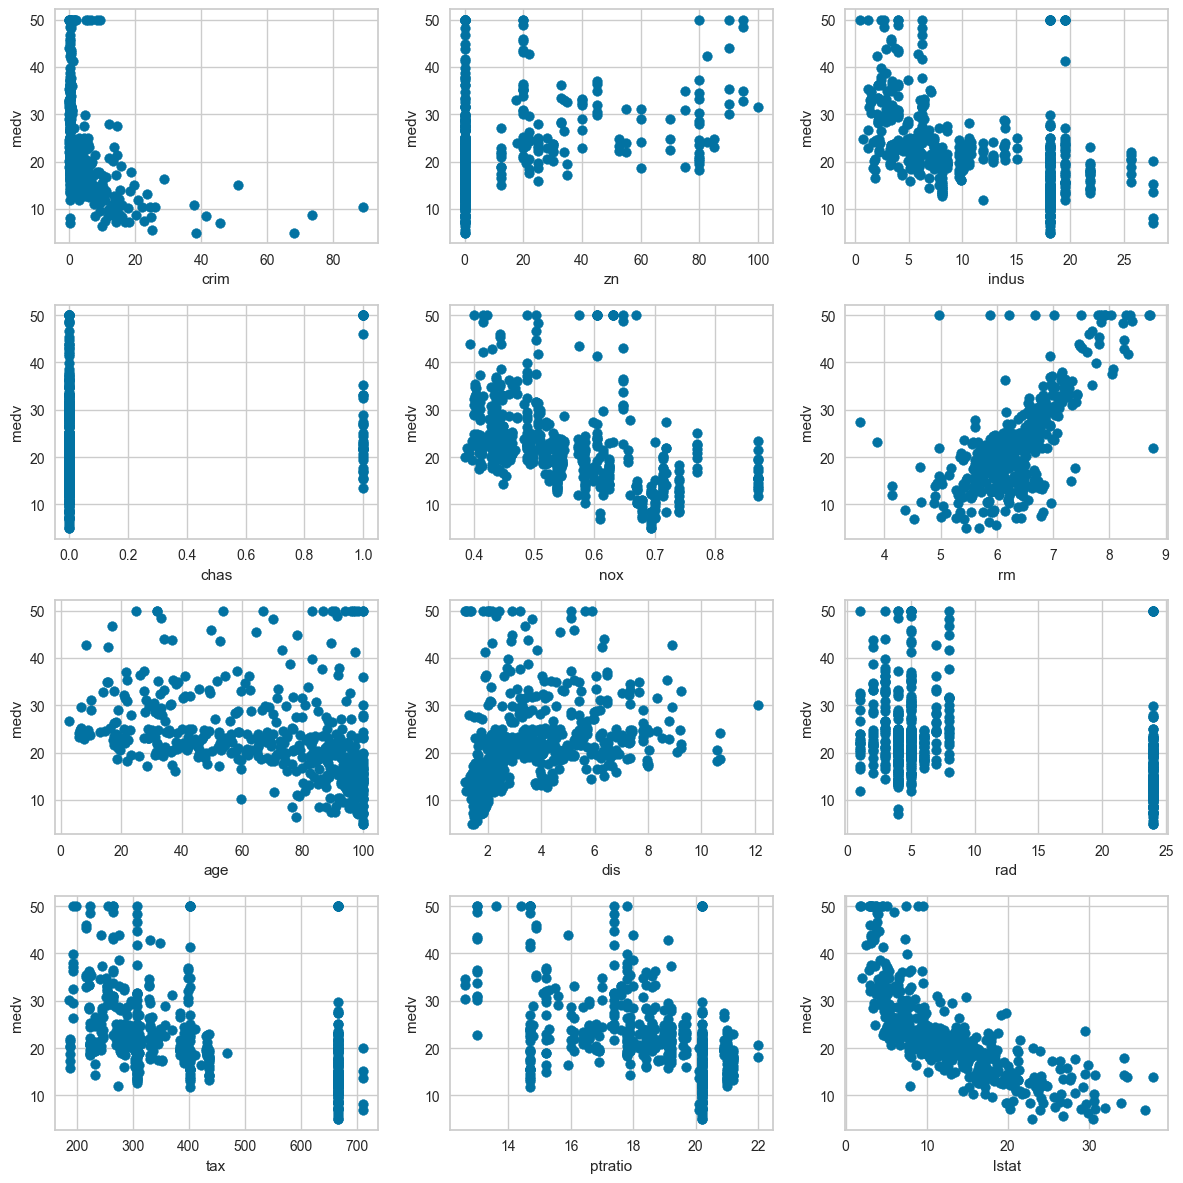

In [275]:
plot_scatter(df)

- High crime areas seem to exclusively have lower values of medv
- The furthest away areas from industry (indus>20) tend to have lower medv
- Seems to be a pattern that higher nox polluted areas have lower medv
- Higher number of rooms seems to be associated with higher medv
- Seems to be a medv "floor: where newer areas with age <40 tend to have at least 20 medv or higher
- High concentration of low dis areas that are low medv
- Seemingly strong negative association between lstat and medv

In [ ]:
def plot_dist(df, feature):
    '''
    Function to plot the distribution of a given feature in the dataframe.
    Computes and displays the average, median, kurtosis, and skewness.
    If the data is highly skewed, it plots the log of the feature.
    '''
    if feature in df.columns:
        data = df[feature] #getting the data for each feature
        #Computing statistics: 
        avg = data.mean()
        median = data.median()
        kurtosis = data.kurtosis()
        skewness = data.skew()
        
        #Plotting: 
        plt.figure(figsize=(8, 5))
        if abs(skewness) > 3:
            #If the data is highly pos/neg skewed, we plot the log of the data:
            sns.histplot(np.log1p(data), kde=True)
            plt.title(f'Log Distribution of {feature}')
            plt.xlabel(f'Log of {feature}')
            #Adding a text box with the statistics:
            plt.text(0.95, 0.95, f'Average: {avg:.2f}\nMedian: {median:.2f}\nKurtosis: {kurtosis:.2f}\nSkewness: {skewness:.2f}',
                     verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, 
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.4))
        else:
            sns.histplot(data, kde=True)
            plt.title(f'Distribution of {feature}')
            plt.xlabel(feature)
            plt.text(0.95, 0.95, f'Average: {avg:.2f}\nMedian: {median:.2f}\nKurtosis: {kurtosis:.2f}\nSkewness: {skewness:.2f}',
                     verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes, 
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.4))
        
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f'Feature "{feature}" not found in the dataframe.')


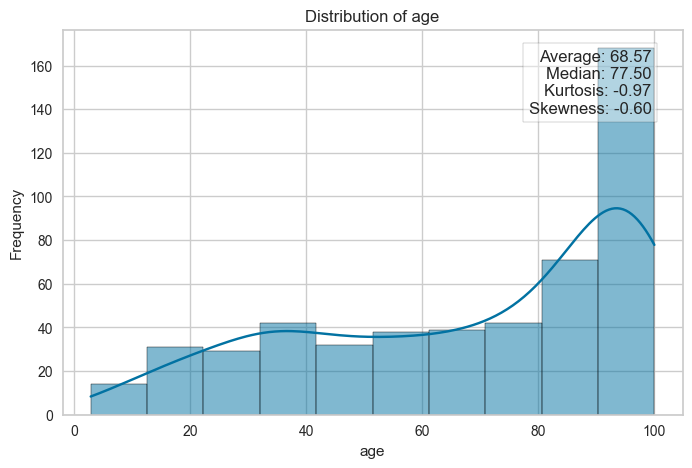

In [277]:
plot_dist(df, 'age')

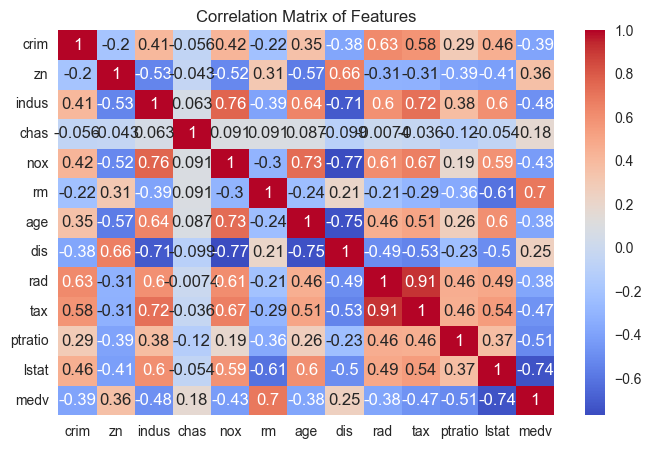

In [ ]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

- rm and lstat are strongly correlated with the target medv
- tax and rad are highly correlated -> may be problematic for certain linear models, but LASSO may shrink one of these coefficients to 0
- interesting to see such a stron negative correlation between distance to job centers and nox pollution & positive correlation between indus and nox

### Feature Engineering

In [279]:
df['dis_nox'] = df['dis'] * df['nox'] # interaction between distance to job centers and nox pollution levels
df['lstat_rm'] = df['lstat'] * df['rm'] # interaction between low income proportion and number of rooms
df['lstat_age'] = df['lstat'] * df['age'] # interaction between low income proportion and age
df['lstat_indus'] = df['lstat'] * df['indus'] # interaction between low income proportion and industry proportion

df['log_crim'] = np.log(df['crim']) # log of crime rate due to high skewness; log1p is log(1 + x) to avoid any log(0) issues

In [280]:
features = [col for col in df.columns if col != 'medv'] # updating the features list with the new columns

### Modeling

In [ ]:
scaler = StandardScaler() #Initializing the scaler for standardization

Since LASSO works by shrinking the size of the coefficients but each coefficient is measured according to the different units of measurement of each variable, the features will be standardised.
MLP may also benefit from this

In [282]:
train, test = train_test_split(df, test_size=0.2) # 20% test size 

In [283]:
X_train = train[features]
X_train_scaled = scaler.fit_transform(X_train)
y_train = train['medv']


X_test = test[features]
X_test_scaled = scaler.transform(X_test)
y_test = test['medv']

In [284]:
rf = RandomForestRegressor(random_state=4122024)
lasso = Lasso(random_state=4122024)
mlp = MLPRegressor(random_state=4122024, max_iter=1000)

In [285]:
def plot_validation_curve(estimator, param_name, param_range, X=X_train, y=y_train, cv=5):
    '''
    Function to plot the validation curve of a given estimator and hyperparameter over a specified range.
    '''
    viz = ValidationCurve(
        estimator, 
        param_name=param_name,
        param_range=param_range, 
        cv=cv, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    viz.fit(X, y)
    viz.show()

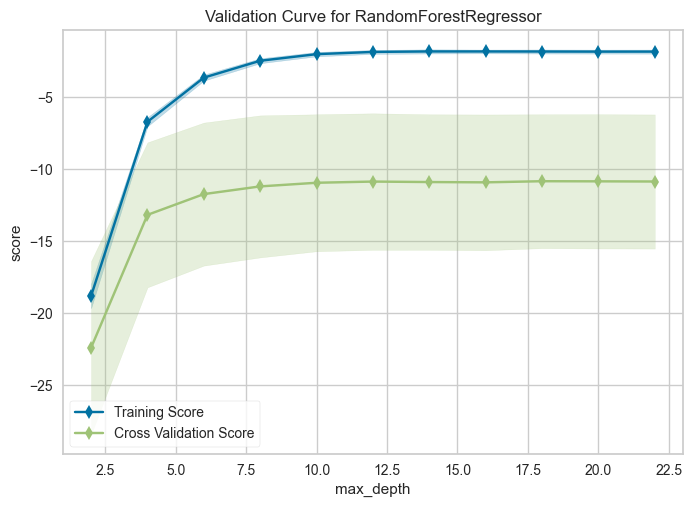

In [286]:
plot_validation_curve(rf, 'max_depth', np.arange(2, 23, 2).tolist())

- n_estimators: no seemingly big impact of number of trees on the loss -> better to keep to small number then to avoid overfitting.
- max_depth: MSE drops from -40 with depth of 2, starts to plateu around a loss of -2 with around max depth of 8
- min_samples_split: MSE worsens with higher numbers of minimum required samples to split. Best not to go above 10. 
- min_samples_leaf: MSE worsens with higher numbers of minimum observations in leaf nodes. Best to keep under 8. 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+00, tolerance: 2.959e+00
  model = cd_fast.enet_coordinate_descent(


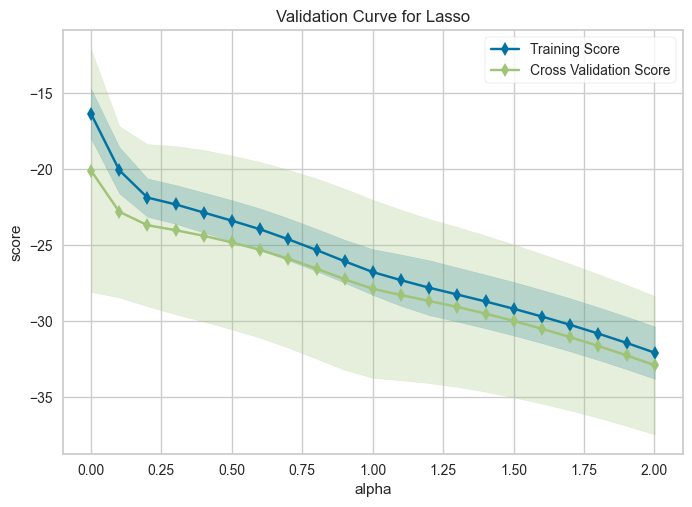

In [287]:
plot_validation_curve(lasso, 'alpha', np.arange(0.001, 2.1, 0.1).tolist(), X=X_train_scaled) # range from 0.001 to 2.0 in increments of 0.1

- Seems that the higher the penalty term of the LASSO the worse the out-of-sample score. So a more "unshrunk" OLS regression is more optimal

In [172]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': np.arange(2, 23, 2).tolist(),
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6]
}

In [174]:
rf_cv = GridSearchCV(
    estimator=rf, #model
    param_grid=rf_param_grid, # hyperparameters to tune
    cv=5, # number of cross-validation folds
    scoring='neg_mean_squared_error', #MSE 
    n_jobs=-1, 
    verbose=1
)

rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 528 candidates, totalling 2640 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=4122024),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [288]:
#Outputting the results of the cross-validation:
rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
# We only want the info on the parameter values, the mean test score, the std. dev, and the rank: 
rf_cv_results = rf_cv_results[[col for col in rf_cv_results.columns if 'param_' in col or 'mean_test' in col or 'std_test' in col or 'rank' in col]] 
rf_cv_results.sort_values('rank_test_score', inplace=True)
rf_cv_results.reset_index(drop=True, inplace=True)
rf_cv_results.head(10)

,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
0,12,2,4,200,-13.263616,6.348837,1
1,12,2,2,200,-13.263616,6.348837,1
2,18,2,2,200,-13.286025,6.330047,3
3,18,2,4,200,-13.286025,6.330047,3
4,20,2,2,200,-13.286422,6.329482,5
5,20,2,4,200,-13.286422,6.329482,5
6,22,2,2,200,-13.286422,6.329482,5
7,22,2,4,200,-13.286422,6.329482,5
8,16,2,4,200,-13.293228,6.321097,9
9,16,2,2,200,-13.293228,6.321097,9


It seems deeper trees tend to be more performant. 

In [289]:
# Select the best performing hyperparameter values:
rf_best = RandomForestRegressor(
    n_estimators=200, 
    max_depth=12, 
    min_samples_split=4,
    min_samples_leaf=2, 
    random_state=4122024
)

rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=200, random_state=4122024)

In [290]:
lasso_cv = GridSearchCV(
    estimator=lasso, 
    param_grid={'alpha': np.arange(0.001, 2.1, 0.1).tolist()}, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

lasso_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.507e+00, tolerance: 2.959e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(random_state=4122024), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.101, 0.201, 0.30100000000000005,
                                   0.401, 0.501, 0.6010000000000001,
                                   0.7010000000000001, 0.801, 0.901, 1.001,
                                   1.101, 1.201, 1.301, 1.401, 1.501, 1.601,
                                   1.701, 1.801, 1.901, 2.001]},
             scoring='neg_mean_squared_error', verbose=1)

In [291]:
lasso_cv_results = pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results = lasso_cv_results[[col for col in lasso_cv_results.columns if 'param_' in col or 'mean_test' in col or 'std_test' in col or 'rank' in col]]
lasso_cv_results.sort_values('rank_test_score', inplace=True)
lasso_cv_results.reset_index(drop=True, inplace=True)
lasso_cv_results.head(10)

,param_alpha,mean_test_score,std_test_score,rank_test_score
0,0.001,-20.101405,7.979147,1
1,0.101,-22.805451,5.640958,2
2,0.201,-23.689169,5.334888,3
3,0.301,-24.019782,5.538715,4
4,0.401,-24.385610,5.645449,5
5,0.501,-24.828030,5.721627,6
6,0.601,-25.316115,5.786876,7
7,0.701,-25.897117,5.854560,8
8,0.801,-26.548878,5.934302,9
9,0.901,-27.250745,5.962274,10


Seems that shrinkage of coefficients is not beneficial for out-of-sample predictions. 

In [292]:
lasso_best = Lasso(alpha=0.001, random_state=4122024)
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=0.001, random_state=4122024)

In [293]:
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (100, 100), (200, 200), (100,100,100), (200,200,200)],
    'alpha': np.logspace(-4, -1, 4).tolist(),
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

In [257]:
mlp_cv = GridSearchCV(
    estimator=mlp, 
    param_grid=mlp_param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    verbose=1
)

mlp_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000, random_state=4122024),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(100,), (200,), (100, 100),
                                                (200, 200), (100, 100, 100),
                                                (200, 200, 200)],
                         'learning_rate_init': [0.0001, 0.001, 0.01]},
             scoring='neg_mean_squared_error', verbose=1)

In [294]:
mlp_cv_results = pd.DataFrame(mlp_cv.cv_results_)
mlp_cv_results = mlp_cv_results[[col for col in mlp_cv_results if 'param_' in col or 'mean_test' in col or 'std_test' in col or 'rank' in col ]]
mlp_cv_results.sort_values(by='rank_test_score', inplace=True)
mlp_cv_results.reset_index(drop=True, inplace=True)
mlp_cv_results.head(20)

,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,mean_test_score,std_test_score,rank_test_score
0,0.1,"(200,)",0.001,-10.907628,3.615239,1
1,0.001,"(200,)",0.001,-10.914845,3.624829,2
2,0.01,"(200,)",0.001,-10.919422,3.620237,3
3,0.0001,"(200,)",0.001,-10.922029,3.621690,4
4,0.001,"(100,)",0.001,-11.497026,3.344179,5
5,0.01,"(100,)",0.001,-11.505971,3.338323,6
6,0.1,"(100,)",0.001,-11.533623,3.312838,7
7,0.0001,"(100,)",0.001,-11.570813,3.482740,8
8,0.01,"(200, 200, 200)",0.0001,-11.620386,3.888555,9
9,0.1,"(200, 200, 200)",0.0001,-11.622576,3.796000,10


Single layer neural net seems to perform better, with a low initial learning rate for slow convergence. 

In [295]:
mlp_best = MLPRegressor(
    hidden_layer_sizes=(200,), 
    alpha=0.1, 
    activation='relu', 
    learning_rate_init=0.001, 
    random_state=4122024, 
)

mlp_best.fit(X_train_scaled, y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(200,), random_state=4122024)

### Predictions and Evaluation

In [296]:
# Predictions
rf_pred = rf_best.predict(X_test)
rf_residual = y_test - rf_pred

lasso_pred = lasso_best.predict(X_test_scaled)
lasso_residual = y_test - lasso_pred

mlp_pred = mlp_best.predict(X_test_scaled)
mlp_residual = y_test - mlp_pred

In [ ]:
def plot_predictions(y_pred, y_test=y_test):
    '''
    Plots a scatter graph of the predicted values versus the actuals
    '''
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, y_test)
    plt.plot([0,max(y_pred)], [0, max(y_test)], color='black', lw=2) #Adjusting the diagonal line to start from 0 and end on the max values
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Predicted vs Actual')
    plt.show()

In [ ]:
def plot_dist_residuals (residuals):
    '''
    Plots the distribution of the residuals for a given model and calculate the mean, median, std. dev, and skewness.
    '''
    # Statistics:
    avg = residuals.mean()
    median = np.median(residuals)
    std_dev = residuals.std()
    skewness = residuals.skew()

    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True)
    # Adding a text box with the statistics:
    plt.text(0.95, 0.95, f'Average: {avg:.2f}\nMedian: {median:.2f}\nStd. Dev: {std_dev:.2f}\nSkewness: {skewness:.2f}',
             verticalalignment='top', horizontalalignment='right',  transform=plt.gca().transAxes, 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.4))
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.show()

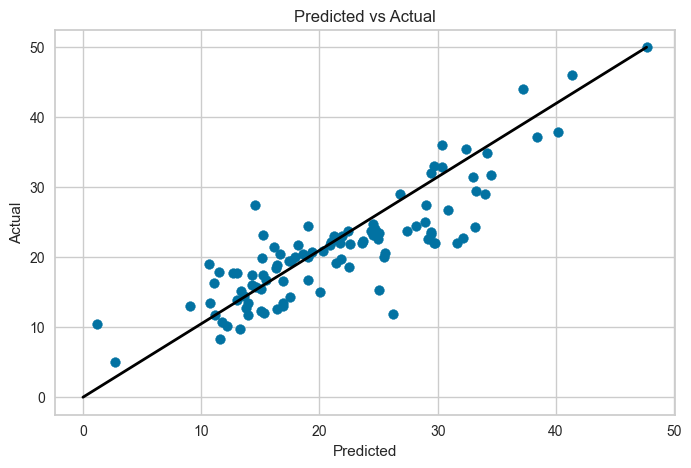

In [299]:
plot_predictions(mlp_pred)

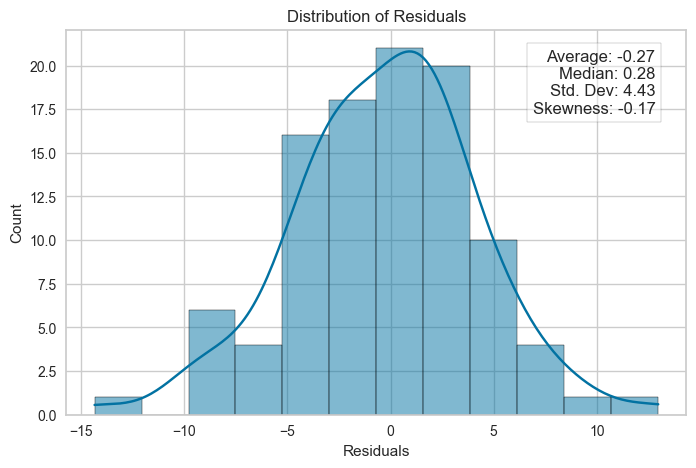

In [300]:
plot_dist_residuals(mlp_residual)

In [ ]:
models = ['rf', 'lasso', 'mlp']

for model in models:
    # For loop to calculate eval metrics and print them for each model:
    y_pred = globals()[f'{model}_pred']
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f'\n--- {model.upper()} ---')
    print(f'MAE: ${round(mae * 1000, 2)}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: ${round(rmse * 1000, 2)}')
    print(f'R^2: {r2:.2f}')


--- RF ---
MAE: $2455.14
MAPE: 14.11%
RMSE: $3510.92
R^2: 0.81

--- LASSO ---
MAE: $2822.31
MAPE: 15.57%
RMSE: $3711.2
R^2: 0.78

--- MLP ---
MAE: $3448.46
MAPE: 18.45%
RMSE: $4416.24
R^2: 0.69


The Random Forest model performs the best on the test set across all metrics (MAE, MAPE, RMSE, and $ R^2 $). Even though it grew very deep trees with small split sizes, it did not overfit the data. 

The MLP neural network performed the worst across all metrics. It seemed to predict poorly especially on medium values of medv. The hyper-parameter tuning results for the MLP model were quite inconsistent, showing good results for shrinkage penalties between 0.1 and 0.0001 and layer structures fom (100,) to (200,200,200). The chosen MLP model was very generalised with a high penalty of 0.1 and a simple 1 layer and 200 neurons which perhaps made it underfit the data. 

### Feature Importances

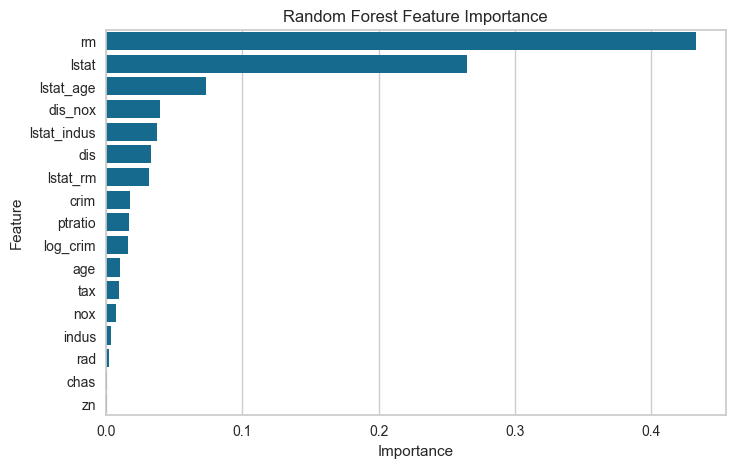

In [ ]:
rf_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_best.feature_importances_
})
rf_feature_importance.sort_values('Importance', ascending=False, inplace=True)
rf_feature_importance.reset_index(drop=True, inplace=True)

#Plotting: 
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [304]:
lasso_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso_best.coef_
}) 
# Adding the absolute value of the coefficients to then sort by asolute size
lasso_coefficients['coefficient_abs'] = lasso_coefficients['Coefficient'].abs() 
lasso_coefficients = lasso_coefficients.sort_values(by='coefficient_abs', ascending=False).reset_index(drop=True)
lasso_coefficients = lasso_coefficients.drop(columns=['coefficient_abs']) # drop the absolute values
lasso_coefficients

,Feature,Coefficient
0,lstat,19.264558
1,lstat_rm,-18.786982
2,rm,6.209127
3,dis_nox,-4.168531
4,lstat_indus,-3.291961
5,dis,2.634880
6,rad,2.270659
7,lstat_age,-2.202788
8,tax,-2.010559
9,indus,1.759047


- It seems that both the LASSO and the RF model both are somewhat in agreement with lstat and rm being the most relevant features for predicting medv. 
- Interaction terms also seem to be important, as 3 out of the top 5 most relevant features for both the RF and LASSO are interaction terms. 
- The RF places almost 70% of its feature importances solely on rm and lstat, whilst the rest of the features don't make it past 0.1 individually. 
- Curiously, the LASSO model does not shrink any coefficients down to 0, although it may be due to the low penalty value. 
